In [1]:
import MDAnalysis
import mdtraj as md
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set_style("white")
#sns.set_style()

# load traj

In [2]:
# RIP bound complex trajs
case_name_1 = '2_2dri-RIP_nowat'
gros_1 = [f'../100_clean_traj/{i}_2dri-RIP_nowat.gro' for i in range(1, 3)]
gros_1 += [f'../100_clean_traj/{i}_2dri-RIP_backrubed_nowat.gro' for i in range(1, 11)]

xtcs_1 = [f'../100_clean_traj/{i}_2dri-RIP_nowat.xtc' for i in range(1, 3)]
xtcs_1 += [f'../100_clean_traj/{i}_2dri-RIP_backrubed_nowat.xtc' for i in range(1, 11)]
u_1 = MDAnalysis.Universe(gros_1[0], xtcs_1)


# apo trajs
case_name_2 = '1_apo_1urp_nowat'
gros_2 = [f'../../MD-CL-7-1/100_clean_traj/{i}_apo_1urp_nowat.gro' for i in range(1, 2)]
gros_2 += [f'../../MD-CL-7-1/100_clean_traj/{i}_apo_1urp_backrubed_nowat.gro' for i in range(1, 11)]

xtcs_2 = [f'../../MD-CL-7-1/100_clean_traj/{i}_apo_1urp_nowat.xtc' for i in range(1, 2)]
xtcs_2 += [f'../../MD-CL-7-1/100_clean_traj/{i}_apo_1urp_backrubed_nowat.xtc' for i in range(1, 11)]
u_2 = MDAnalysis.Universe(gros_2[0], xtcs_2)

In [3]:
print(u_1.trajectory)
print(u_2.trajectory)

<ChainReader containing 1_2dri-RIP_nowat.xtc and 11 more with 170012 frames of 4080 atoms>
<ChainReader containing 1_apo_1urp_nowat.xtc and 10 more with 250011 frames of 4060 atoms>


# Hbond_diff

In [4]:
from md_utility.hbond import *
from md_utility.utils import plot_on_pdb

max_per_res_1 = run_hbond_analysis(case_name_1, u_1)
max_per_res_2 = run_hbond_analysis(case_name_2, u_2)

2_2dri-RIP_nowat_hbond.npy file loaded
1_apo_1urp_nowat_hbond.npy file loaded


In [5]:
def clean_df(df, index_name):
    import re
    df = df.reset_index()
    df['resnum'] = df[index_name].apply(lambda x: re.search('[A-Z]*(\d*).*', x).group(1))
    df['resnum']  = df['resnum'].astype(np.int64)
    df = df.sort_values(by='resnum')
    df.reset_index(inplace=True, drop=True)
    return df.drop(columns='resnum')

clean_df(max_per_res_1, 'donor')

,donor,hydrogen,acceptor,hbond_ratio
0,ASP2-N,ASP2-HN,GLY31-O,0.043044
1,THR3-N,THR3-HN,LYS1-O,0.006656
2,ILE4-N,ILE4-HN,ASN33-O,23.112856
3,ALA5-N,ALA5-HN,LYS59-O,18.918035
4,LEU6-N,LEU6-HN,VAL35-O,22.788175
...,...,...,...,...
219,LYS266-N,LYS266-HN,ALA234-O,11.032057
220,VAL268-N,VAL268-HN,THR232-O,22.102277
221,VAL269-N,VAL269-HN,LEU267-O,0.000148
222,LYS270-N,LYS270-HN,ALA230-O,7.556416


In [6]:
clean_df(max_per_res_2, 'donor')

,donor,hydrogen,acceptor,hbond_ratio
0,ASP2-N,ASP2-HN,GLY31-O,0.014332
1,THR3-N,THR3-HN,LYS1-O,0.000500
2,ILE4-N,ILE4-HN,ASN33-O,23.166634
3,ALA5-N,ALA5-HN,ILE60-O,18.663798
4,LEU6-N,LEU6-HN,VAL35-O,22.808161
...,...,...,...,...
218,LYS266-N,LYS266-HN,ALA234-O,21.850731
219,VAL268-N,VAL268-HN,THR232-O,21.833899
220,VAL269-N,VAL269-HN,LEU267-O,0.000333
221,LYS270-N,LYS270-HN,ALA230-O,4.834645


In [7]:
pdb_file = '../2_2dri-RIP_MD/1_2dri-RIP.pdb'
u_plot = plot_on_pdb(case_name_1, pdb_file, df_per_res_1=max_per_res_1, df_per_res_2=max_per_res_2,
                     column_name='hbond_ratio', save_pdb=True)

/home/chenlin/anaconda3/envs/MD/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/chenlin/anaconda3/envs/MD/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/chenlin/anaconda3/envs/MD/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [8]:
CA_atoms = u_plot.select_atoms('name CA')
df = pd.DataFrame({'resnum': CA_atoms.resnums, 'hbond_ratio_diff': CA_atoms.tempfactors})

In [9]:
' '.join(list(df[df['hbond_ratio_diff'] > 3].resnum.astype(str)))

'17 54 71 72 75 87 90 93 144 145 194 232 233 235 250'

In [10]:
' '.join(list(df[df['hbond_ratio_diff'] < -3].resnum.astype(str)))

'39 64 70 104 212 234 236 266'

In [48]:
def coarse_grain_hbond_diff(df, start=1, stop=2):
    return sum(df['hbond_ratio_diff'][start-1+2:stop-1])

In [49]:
df

,resnum,hbond_ratio_diff,hbond_ratio_diff_smoothed
0,1,0.000000,0.009316
1,2,0.028712,0.020666
2,3,0.006156,-0.027396
3,4,-0.053779,0.062409
4,5,0.254237,0.109269
...,...,...,...
266,267,0.000000,-3.617228
267,268,0.268378,0.824312
268,269,-0.000185,1.000056
269,270,2.721771,1.374079


In [50]:
coarse_grain_hbond_diff(df, start=35, stop=40)

-8.413678117994506

In [51]:
heat_map_df = pd.read_csv('../200_hdx/10-18-rbsb_plotting_only-for-uptake-plot/plots/Apo-Rib-heatmapdf.csv', index_col=0)
hbond_diff_sum = []
for index, row in heat_map_df.iterrows():
    start = row['Start']
    stop = row['End']
    pep_sum = coarse_grain_hbond_diff(df, start=start, stop=stop)
    hbond_diff_sum.append(pep_sum)
heat_map_df['hbond_diff_sum'] = pd.Series(hbond_diff_sum)

In [52]:
heat_map_df.describe()

,Sensitivity,Start,End,hbond_diff_sum
count,171.000000,171.000000,171.000000,171.000000
mean,0.049647,126.573099,137.590643,3.186408
std,0.039722,76.186607,76.481576,5.607524
min,-0.010030,6.000000,12.000000,-11.200048
25%,0.021235,54.000000,62.500000,0.096577
50%,0.039595,132.000000,147.000000,2.988289
75%,0.064368,194.000000,201.000000,6.582364
max,0.215824,261.000000,268.000000,19.516974


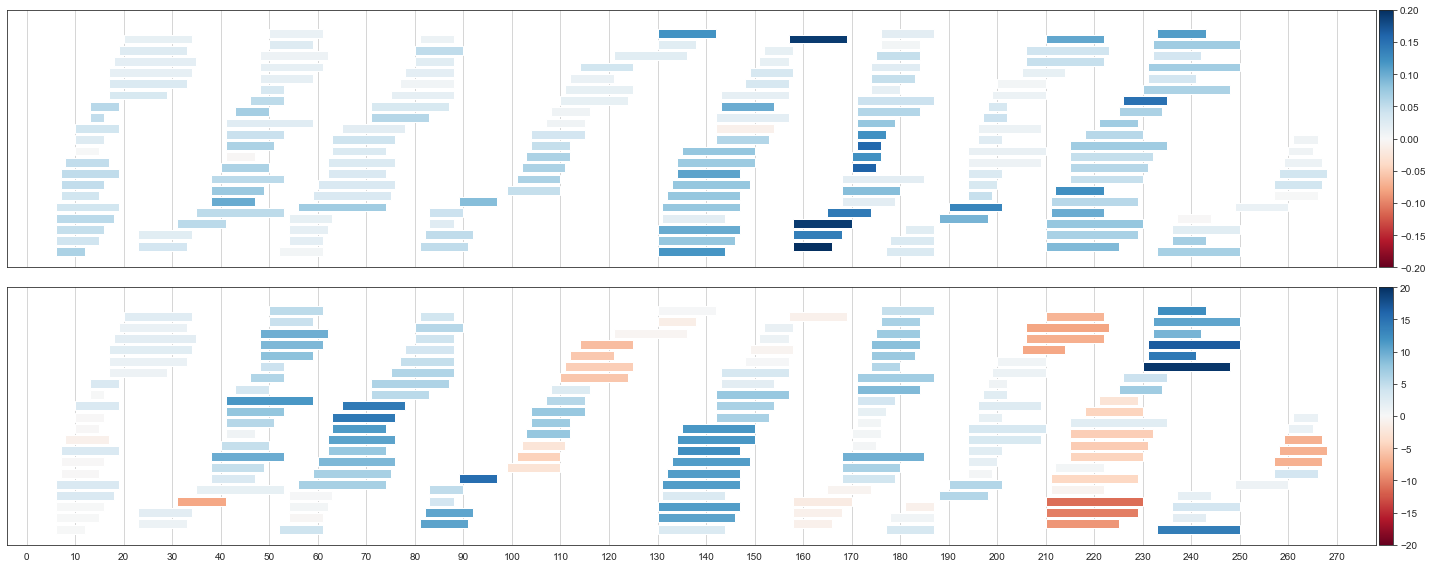

In [53]:
import matplotlib.colors as col
from matplotlib.patches import Rectangle
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#colmap = plt.get_cmap("Blues")
colmap = plt.get_cmap("RdBu")


colorbar_maxs = [0.2, 20]
plol_y_datas = ['Sensitivity' ,'hbond_diff_sum']
fig, axes = plt.subplots(2, 1, figsize=(20,8), sharey=True, sharex=True)
for plol_i in range(2):
    colorbar_max = colorbar_maxs[plol_i]
    ax = axes.flatten()[plol_i]
    leftbound = heat_map_df['Start'][0]-10
    rightbound = max(heat_map_df['End'])+10
    ax.set_xlim(leftbound,rightbound)
    ax.xaxis.set_ticks(np.arange(round(leftbound,-1), round(rightbound,-1), 10))
    ax.set_ylim(-5,110)
    ax.grid(axis='x')
    ax.yaxis.set_ticks([])
    norm = col.Normalize(vmin=-colorbar_max,vmax=colorbar_max)
    for i in range(len(heat_map_df['Start'])):
        ax.add_patch(Rectangle((heat_map_df['Start'][i], (i%20)*5 + ((i//20)%2)*2.5), heat_map_df['End'][i]-heat_map_df['Start'][i],4, fc=colmap(norm(heat_map_df[plol_y_datas[plol_i]][i]))))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='1%', pad=0.05)
    fig.colorbar(cm.ScalarMappable(cmap=colmap, norm=norm), cax=cax)
plt.tight_layout()
#fig.savefig('hbond/figures/hbond_sum_compare_with_hdx.png',dpi=600)

In [20]:
def plot_2pfk(data_df, x, y, save_path=None):

    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    sns.lineplot(data=data_df, x=x, y=y)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.tick_params(axis='x', labelrotation=0)
    #ax.set_xlim(-5, 325)
    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path)

In [21]:
from scipy.signal import savgol_filter

In [22]:
df['hbond_ratio_diff_smoothed'] = savgol_filter(df['hbond_ratio_diff'], 5, 3, mode='nearest')

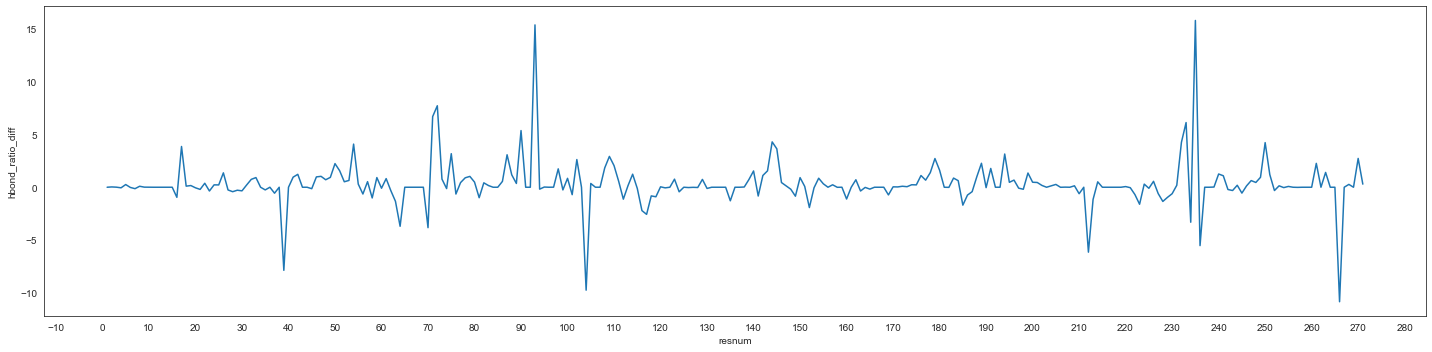

In [23]:
plot_2pfk(df, x='resnum', y='hbond_ratio_diff', save_path=f'./hbond/figures/{case_name_1}_hbond_ratio_diff.pdf')

In [ ]:
plot_2pfk(df, x='resnum', y='hbond_ratio_diff', save_path=f'./hbond/figures/{case_name_1}_hbond_ratio_diff.pdf')

In [ ]:
plot_2pfk(df, x='resnum', y='hbond_ratio_diff_smoothed',save_path=f'./hbond/figures/{case_name_1}_hbond_ratio_diff_smoothed.pdf')

# SASA_diff

In [ ]:
from md_utility.sasa import *

In [ ]:
sasa_res_1 = get_sasa_res(traj_1[1000:], case_name_1)
sasa_df_1, sasa_mean_df_1 = parse_sasa(case_name_1, top_file_1, sasa_res_1)

sasa_res_2 = get_sasa_res(traj_2[1000:], case_name_2)
sasa_df_2, sasa_mean_df_2 = parse_sasa(case_name_2, top_file_2, sasa_res_2)

In [ ]:
sasa_diff = sasa_mean_df_1 - sasa_mean_df_2
sasa_diff.reset_index(inplace=True)

In [ ]:
threshold = sasa_mean_df_1.describe()['sasa']['75%']
sasa_mean_df_1.clip(upper=threshold)/threshold

In [ ]:
sasa_mean_df_1/sasa_mean_df_1.max()

In [ ]:
sasa_diff

In [ ]:
plot_2pfk(sasa_mean_df_2, x='residue', y='sasa')

In [ ]:
plot_2pfk( sasa_diff, x='residue', y='sasa')

# hbond combined with sasa

In [ ]:
def get_un_hbond_ratio_sasa(case_name, df_hbond, df_sasa):
    u_plot = plot_on_pdb(case_name, pdb_file, df_per_res_1=df_hbond,
                     column_name='hbond_ratio', save_pdb=False)
    CA_atoms = u_plot.select_atoms('name CA')
    df = pd.DataFrame({'resnum': CA_atoms.resnums, 'hbond_ratio': CA_atoms.tempfactors})
    df = df.groupby('resnum').mean().reset_index()

    df['sasa'] = df_sasa.reset_index()['sasa']
    threshold = df.describe()['sasa']['75%']
    df['sasa'] = df['sasa'].clip(upper=threshold)/threshold
    df['un_hbond_ratio * sasa'] = (100 - df['hbond_ratio'])* df['sasa']/df['sasa'].max()
    return df

In [ ]:
df1 = get_un_hbond_ratio_sasa(case_name_1, max_per_res_1, sasa_mean_df_1)

plot_2pfk(f'./hbond/figures/{case_name_1}_un_hbond_ratio-sasa_test.pdf', df1, x='resnum', y='un_hbond_ratio * sasa')


In [ ]:
df2 = get_un_hbond_ratio_sasa(case_name_2, max_per_res_2, sasa_mean_df_2)
plot_2pfk(f'./hbond/figures/{case_name_2}_un_hbond_ratio-test2.pdf', df2, x='resnum', y='un_hbond_ratio * sasa')


In [ ]:
sub_df = df1 - df2
sub_df['resnum'] = df1['resnum']

In [ ]:
sub_df

In [ ]:
plot_2pfk(f'./hbond/figures/{case_name_2}_un_hbond_ratio-sasa_diff_test.pdf', sub_df , x='resnum', y='un_hbond_ratio * sasa')

In [ ]:
sasa_mean_df_1.loc[175]